In [1]:
# from debias_transformers import RobertaTokenizer, RobertaForSequenceClassification
from debias_transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import torch
from tqdm import tqdm, trange

import logging
logging.basicConfig(level=logging.INFO)

import pandas as pd
import numpy as np

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from pycm import ConfusionMatrix

import os
import sys 
sys.path.insert(0, os.path.abspath(os.path.join('..')))
from train import Train as RobBERTTrainer
from textdataset import TextDataset, load_and_cache_examples

In [2]:

# %load_ext autoreload
# %autoreload 2
import debias_finetunning as sen_debias

## Change per model:

1. Model imports (e.g. BertTokenizer -> RobertaTokenizer)
    - model name
2. File where bias_subspace is.
3. Examples files 
    - load_and_cache_examples("bert", tokenizer, "../../Rodrigo-data/Finetuning/dbrd/train")
4. Change name of file_pickle_stats to save stats and dont override
5. Where we save the model output_dir = "../../Rodrigo-data/Finetuning/dbrd/v2/bert_debiased/"


In [3]:
tokenizer = BertTokenizer.from_pretrained("wietsedv/bert-base-dutch-cased")
# tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robBERT-base")

INFO:debias_transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/wietsedv/bert-base-dutch-cased/vocab.txt from cache at /home/ubuntu/.cache/torch/transformers/75d9be4cc7910048b3bdd477c435ffc46330193705f74eaf9a4f375cd3be28b2.1e00a56207196ed1759c49bdd1fa93c2fb20273d59fabb0c4c8092f7beb773c2


In [4]:
model = BertForSequenceClassification.from_pretrained("wietsedv/bert-base-dutch-cased")
logging.info("loaded BERTJe")

INFO:debias_transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/wietsedv/bert-base-dutch-cased/config.json from cache at /home/ubuntu/.cache/torch/transformers/6702c5c53edb76b65d71f73ff2d9811ba62f16257ea58e36dedceffd71290a6a.1a78bd120fe46d78b55efa59f4ffa1dafcc9242743ab9fd6629d1b56672c9119
INFO:debias_transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 3,
  "type_vocab_size": 2,
  "vocab_size": 30000
}

INFO:debias_transformers.modeling_utils:loading weights file https://cdn.huggingface.co/wietsedv/bert-base-dutch

## Create a training config

In [5]:
from train_config import Config
config = Config()
config.model_type = 'bert'
config.evaluate_dataset = "../../Rodrigo-data/Finetuning/dbrd/eval"

## Create bias direction

In [6]:
#Get bias dir
# Rodrigo-data/bias_subspace/bias_subspace_k10_nl_large30000k.npy
# file_bias_subspace = "../../Rodrigo-data/bias_subspace/Robbert_ForFinetune-bias_subspace_k50_nl_large30000k" #Robbert bias
file_bias_subspace = "../../Rodrigo-data/bias_subspace/bias_subspace_k50_nl_large30000k" #Bert bias

bias_subspace = sen_debias.get_bias_direction(model,tokenizer, #reload from cache 
    from_cache = True,    
    filename_cache= file_bias_subspace)
bias_direction = bias_subspace[0] #just use the direction for testing   
bias_direction = torch.tensor(bias_direction).to(torch.device("cuda"))

In [7]:
bias_direction.shape

torch.Size([768])

## Load in the data
We use `load_and_cache_examples` to load in the training data, this will produce a tokenized version with torch tensors.

For the test and evaluation sets, we'll use the following `evaluate` function, since we're in the end interested in a dataframe with all inputs and predictions.

In [8]:
def evaluate(dataset, model,debias,bias_dir):
    df = pd.read_table(dataset + ".labels.txt", header=None, names=['labels'])
    df['sentence'] = pd.read_table(dataset + ".sentences.txt", header=None, names=['sentence'])
    model.eval() # disable dropout etc.
    
    mask_padding_with_zero = True
    block_size = 512
    results = []

    # file_bias_subspace = "../Rodrigo-data/bias_subspace/bias_subspace_k"+str(k_dim_file)+"_nl_large"+str(pairs_aumount)+"k"
    # bias_dir = sen_debias.get_bias_direction(model_nl,tokenizer_nl,from_cache = True,filename_cache= file_bias_subspace)
    for row in tqdm(df.iterrows(), total=len(df), mininterval=1, position=1, leave=True):
        index = row[0]
        sentence = row[1]['sentence']
        label = row[1]['labels']

        #tokens = roberta.encode(sentence)
        tokenized_text = tokenizer.tokenize(sentence)[-block_size + 3: -1]
        if len(tokenized_text) is 0: #avoid sentence that couldnt be tokenized in bertje
                            continue
        tokenized_text = tokenizer.encode(tokenized_text)
        # tokenized_text = tokenizer.encode(tokenizer.tokenize(sentence)[- block_size + 3 : -1])

        input_mask = [1 if mask_padding_with_zero else 0] * len(tokenized_text)

        pad_token = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
        while len(tokenized_text) < block_size:
            tokenized_text.append(pad_token)
            input_mask.append(0 if mask_padding_with_zero else 1)
            #segment_ids.append(pad_token_segment_id)
            #p_mask.append(1)

        #self.examples.append([tokenizer.build_inputs_with_special_tokens(tokenized_text[0 : block_size]), [0], [0]])
        batch = tuple(torch.tensor(t).to(torch.device("cuda")) for t in [tokenized_text[0 : block_size - 3], input_mask[0 : block_size- 3], [0], [1] if label else [0]])

        inputs = {"input_ids": batch[0].unsqueeze(0), "attention_mask": batch[1].unsqueeze(0), "labels": batch[3].unsqueeze(0), 
        "remove_bias":debias,"bias_dir":bias_direction,
         "token_type_ids" : batch[2].unsqueeze(0)
         }
        with torch.no_grad():
            outputs = model(**inputs)

            results.append({"true": label, "predicted": outputs[1][0].argmax().item()})

    model.train() # make sure the model is back in training mode
    return results

In [9]:
train_dataset = load_and_cache_examples("bert", tokenizer, "../../Rodrigo-data/Finetuning/dbrd/train")

INFO:textdataset:Creating features from dataset file at ../../Rodrigo-data/Finetuning/dbrd
../../Rodrigo-data/Finetuning/dbrd/train
INFO:textdataset:Saving features into cached file ../../Rodrigo-data/Finetuning/dbrd/bert_cached_lm_512_train


In [10]:
model.train()
logging.info("Put BERT in training mode")

INFO:root:Put BERT in training mode


In [11]:
# You can use the following code to adjust the training size to experiment with the benefits of pretraining. It will not likely get better though ...
# train_dataset.examples  = train_dataset.examples[:100]
# 46min after iteration 1:13

In [12]:
DEBIAS_BOOL = True #Used to indicate whether to debias or not accross the notebook

In [13]:
# Random interesting insight, num examples with bertje is 19525 while in robbert is 19528, this is probably due to some bad sentences 
# in the data which robbert could tokenize while bert tokenizer kept crashing so had to avoid the tokenized sentences with 0 elements.  -Rodrigo
RobBERTTrainer.train(config, train_dataset, model, tokenizer, evaluate,debias=DEBIAS_BOOL, bias_dir=bias_direction)

INFO:train:***** Running training *****
INFO:train:  Num examples = 19525
INFO:train:  Num Epochs = 4
INFO:train:  Instantaneous batch size per GPU = 4
INFO:train:  Total train batch size (w. parallel, distributed & accumulation) = 32
INFO:train:  Gradient Accumulation steps = 8
INFO:train:  Total optimization steps = 2000
Iteration: 100%|██████████| 4882/4882 [11:15<00:00,  7.22it/s, learning_rate=3.97e-5, loss=0.394, step=610]

100%|██████████| 500/500 [00:09<00:00, 54.71it/s]
INFO:train:Results on eval: {'eval_f1_macro': 0.9278415116166971, 'eval_acc_macro': 0.9278557114228457, 'eval_acc_overall': 0.9278557114228457}
Iteration: 100%|██████████| 4882/4882 [11:17<00:00,  7.21it/s, learning_rate=2.23e-5, loss=0.345, step=1220]

100%|██████████| 500/500 [00:09<00:00, 53.54it/s]
INFO:train:Results on eval: {'eval_f1_macro': 0.9619085499857374, 'eval_acc_macro': 0.9619238476953907, 'eval_acc_overall': 0.9619238476953907}
Iteration: 100%|██████████| 4882/4882 [11:16<00:00,  7.22it/s, learn

(2001, 0.2810748317155583)

## Evaluate our trained model

In [14]:
model.eval()
logging.info("putting model in eval mode")

INFO:root:putting model in eval mode


In [15]:
results = pd.DataFrame(evaluate("../../Rodrigo-data/Finetuning/dbrd/test", model,debias=DEBIAS_BOOL, bias_dir=bias_direction))


100%|██████████| 2224/2224 [00:41<00:00, 54.03it/s]


In [16]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, aspect="equal")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(len(tick_marks) - 0.5, -0.5)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1046   66]
 [  54 1058]]


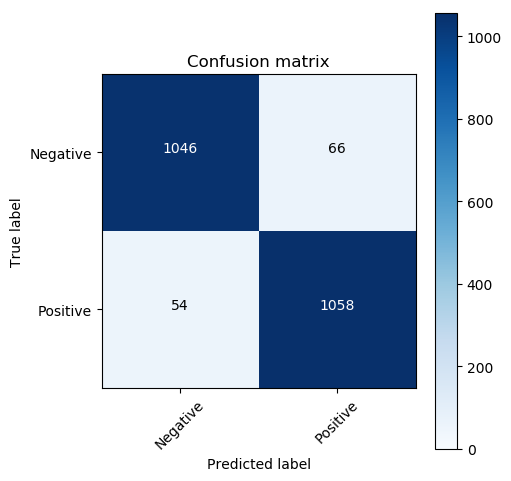

In [17]:
cnf_matrix = confusion_matrix(results['true'], results['predicted'] ) # index to evaluate partial runs

np.set_printoptions(precision=2)

title="Confusion matrix"

# Plot normalized confusion matrix
fig = plt.figure(figsize=(5,5), dpi=100)
#fig.set_size_inches(6,6)

plot_confusion_matrix(cnf_matrix, classes=["Negative", "Positive"],normalize=False, 
                      title=title, cmap=plt.cm.Blues)


In [18]:
cm = ConfusionMatrix(actual_vector=results['true'].values, predict_vector=results['predicted'].values )

In [19]:
cm.stat()

Overall Statistics : 

95% CI                                                            (0.93665,0.95543)
ACC Macro                                                         0.94604
ARI                                                               0.79573
AUNP                                                              0.94604
AUNU                                                              0.94604
Bangdiwala B                                                      0.89503
Bennett S                                                         0.89209
CBA                                                               0.94096
CSI                                                               0.89214
Chi-Squared                                                       1770.10542
Chi-Squared DF                                                    1
Conditional Entropy                                               0.30256
Cramer V                                                          0.89214
Cross En

In [20]:
import pickle
# file_pickle_stats =  "../../Rodrigo-data/Finetuning/dbrd/v2/cm_stat_bertje_debiased"

file_pickle_stats =  "../../Rodrigo-data/Finetuning/dbrd/v2/cm_stat_bertje_debiased"
pickle.dump( cm, open(file_pickle_stats+".p", "wb" ))
st_test =pickle.load( open(file_pickle_stats+".p", "rb" ))
cm.save_csv(file_pickle_stats) #save csv for easy to read


{'Status': True,
 'Message': '/home/ubuntu/thesis/Rodrigo-Debias-Dutch-Embeddings/Rodrigo-notebooks/Finetuning/../../Rodrigo-data/Finetuning/dbrd/v2/cm_stat_bertje_debiased.csv'}

## Saving the model

In [21]:
from transformers import WEIGHTS_NAME, CONFIG_NAME

# output_dir = "../../Rodrigo-data/Finetuning/dbrd/v2/bert_debiased/"
output_dir = "../../Rodrigo-data/Finetuning/dbrd/v2/bert_debiased/"

# Step 1: Save a model, configuration and vocabulary that you have fine-tuned

# If we have a distributed model, save only the encapsulated model
# (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
model_to_save = model.module if hasattr(model, 'module') else model

# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
output_config_file = os.path.join(output_dir, CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(output_dir)

('../../Rodrigo-data/Finetuning/dbrd/v2/bert_debiased/vocab.txt',)